###  Exercise project 3 – Support Vector Machines. This notebook will create SVM-classification model. I will use dataset from Project_2:HR Employee Attrition dataset (https://www.kaggle.com/datasets/saurabhbadole/hr-employee-attrition). Target variable - "Attrition" column (show how likely someone is to quit).The cleaning/optimisation phase is copied from Project_1, so you can scrow down straight to "scale of  the regression target for SVC" 

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [25]:
# load the dataset:
df = pd.read_csv("HR-Employee-Attrition.csv")

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [26]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [27]:
columns_to_drop = [
    'Over18',
    'EmployeeCount',
    'EmployeeNumber',
    'Department',
    'EducationField',
    "Education",
    "MaritalStatus",
    "OverTime",
    "JobRole",
    "StandardHours",
    'Gender',
    'HourlyRate',
    'MonthlyRate',
    'RelationshipSatisfaction',
    'DistanceFromHome',
    'PerformanceRating',
    'NumCompaniesWorked',
    'PercentSalaryHike',
]

df = df.drop(columns_to_drop, axis=1)

In [28]:
# use of OneHotEncoder for "BusinessTravel" column , it will create multiple columns with numeric values:
from sklearn.preprocessing import OneHotEncoder
variables = ["BusinessTravel"]
             
# use encoder:
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [29]:
# next we will remove one new boolean variable "BusinessTravel_Travel_Rarely" (since it's going to be represented
# by a straight line of zeroes)
df = df.drop("BusinessTravel_Travel_Rarely", axis=1)

In [30]:
from sklearn.preprocessing import LabelEncoder
# list of all boolean variables we want to convert
variables = ['Attrition']

# initalize encoder and convert everything
encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

###  X/y -split + VIF -test

In [31]:
 # use everything else except, the target
X = df.drop("Attrition", axis=1)

# our target variable is y
y = df['Attrition']

In [32]:
# Finding columns with potential multicollinearity (VIF-test)
# pip install statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# VIF dataframe 
# VIF = Variance Inflation Factor
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  

# variables with high VIF-value 
# can mean multlicollinearity (variables providing same linear
# relationships in the data, confusing the logistic regression
print(vif_data)

                             feature        VIF
0                                Age  26.256503
1                          DailyRate   4.796366
2            EnvironmentSatisfaction   6.701236
3                     JobInvolvement  13.036970
4                           JobLevel  48.877574
5                    JobSatisfaction   6.567311
6                      MonthlyIncome  30.994836
7                   StockOptionLevel   1.881405
8                  TotalWorkingYears  13.345172
9              TrainingTimesLastYear   5.397656
10                   WorkLifeBalance  13.027862
11                    YearsAtCompany  10.011322
12                YearsInCurrentRole   6.397829
13           YearsSinceLastPromotion   2.440140
14              YearsWithCurrManager   6.440338
15         BusinessTravel_Non-Travel   1.151701
16  BusinessTravel_Travel_Frequently   1.268554


In [33]:
columns_to_drop_after_vif = [
    'Age',
    'MonthlyIncome',
    'WorkLifeBalance',
    'YearsAtCompany', 
    'JobLevel',
    'JobInvolvement',
    'YearsInCurrentRole', 
    'EnvironmentSatisfaction',
]

df = df.drop(columns_to_drop_after_vif, axis=1)

In [34]:
df.describe()

,Attrition,DailyRate,JobSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,0.161224,802.485714,2.728571,0.793878,11.279592,2.799320,2.187755,4.123129,0.102041,0.188435
std,0.367863,403.509100,1.102846,0.852077,7.780782,1.289271,3.222430,3.568136,0.302805,0.391193
min,0.000000,102.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,465.000000,2.000000,0.000000,6.000000,2.000000,0.000000,2.000000,0.000000,0.000000
50%,0.000000,802.000000,3.000000,1.000000,10.000000,3.000000,1.000000,3.000000,0.000000,0.000000
75%,0.000000,1157.000000,4.000000,1.000000,15.000000,3.000000,3.000000,7.000000,0.000000,0.000000
max,1.000000,1499.000000,4.000000,3.000000,40.000000,6.000000,15.000000,17.000000,1.000000,1.000000


In [35]:
len(df.columns)

10

#### Explanation how I did cleaning of the dataset is it Project_2. At this stage I have the same amount of rows and columns and dataset is ready for  X/y and train/test split

In [36]:
# use everything else except, the target
X = df.drop("Attrition", axis=1)

# our target variable is y
y = df['Attrition']

In [37]:
# create train/test split with scikit-learn's helper function
# random_state is optional, you can lock down the randomness for same results everytime
# this is sometimes helpful when you want to minimize randomness in order to maximize optimizations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [38]:
# initialize the scaler and process X-values
# IN MOST CASES you can experiment with MinMaxScaler 
# and StandardScaler, ONLY USE ONE SCALER AT A TIME
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# use fit_transform only once in the beginning
# and use transform after that everywhere
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

###  Applying GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# initialize testable parameters
# NOTE! all algorithms do not support all parameters
# see notes below which you can use with which
# # SVR() -> C, kernel, degree (if using poly), gamma, C, epsilon, max_iter
param_grid = {
    # First version:
#    'C': [0.1, 0.25, 0.5, 1, 1.25, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 2],
    #'epsilon': [0.075, 0.1, 0.125],
#    'gamma': [1, 0.25, 0.1, 0.05, 0.025, 0.01], 
#    'kernel': ['rbf', 'linear']
    # Second version:
    'C': [0.1, 0.5, 1, 1.5, 2],
    'gamma': [1, 0.1, 0.01, 0.001], 
    'kernel': ['rbf', 'linear'],
    'class_weight': [None, 'balanced']
}

# start finding the optimal parameters with GridSearchCV!
test_model = GridSearchCV(
    estimator=SVC(probability=True),
    param_grid=param_grid,
    verbose=3,
    n_jobs=-1,
    cv=5,
    scoring='f1'  # using F1 to account for class imbalance
)

test_model.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 1.5, 2],
                         'class_weight': [None, 'balanced'],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             scoring='f1', verbose=3)

In [ ]:
test_model.best_params_

{'C': 2, 'gamma': 0.1, 'kernel': 'rbf'}

#### Best parameters are the same for both versions. 

In [ ]:
sfafa

NameError: name 'sfafa' is not defined

In [ ]:
# code as usual
model = svm.SVC(C=2, gamma=0.1, kernel='rbf')
model.fit(X_train, y_train)

SVC(C=2, gamma=0.1)

In [ ]:
# get the test predictions for metrics as usual
predictions = model.predict(X_test)

In [ ]:
# print the classification report based on true values and predictions
print(classification_report(y_test, predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.85      0.99      0.92       371
           1       0.64      0.10      0.17        70

    accuracy                           0.85       441
   macro avg       0.74      0.54      0.54       441
weighted avg       0.82      0.85      0.80       441


Model overall accuracy: 84.81%


#### A bit better than without using GridSearchCv.

[[367   4]
 [ 63   7]]


<Axes: >

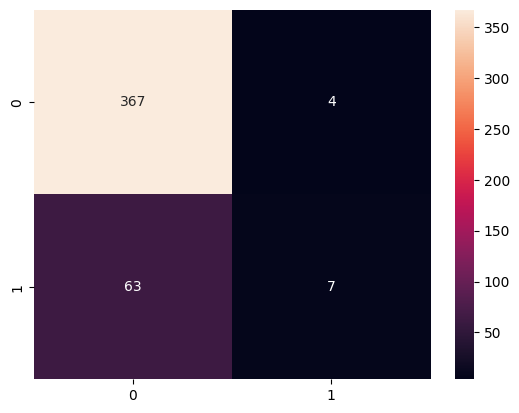

In [ ]:
print(confusion_matrix(y_test, predictions))

# if you want a more graphical version of this, try:
# the fmt-parameter will change to decimal format from scientific format
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

#### Only 7 out of 70 actual attrition cases were correctly identified. 63 cases of attrition were missed completely. So, the model is heavily biased toward predicting "No Attrition" due to class imbalance. I will try to find better hyperparameters parameters but due to imbalance target variable it may not help much. P.S. Additional testing (version 2) with different SVC parameter values confirmed that the imbalance limited performance.